Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 - Train Loss: 0.6718, Test Loss: 0.6161
Epoch 2/3 - Train Loss: 0.5766, Test Loss: 0.5365
Epoch 3/3 - Train Loss: 0.4602, Test Loss: 0.4169


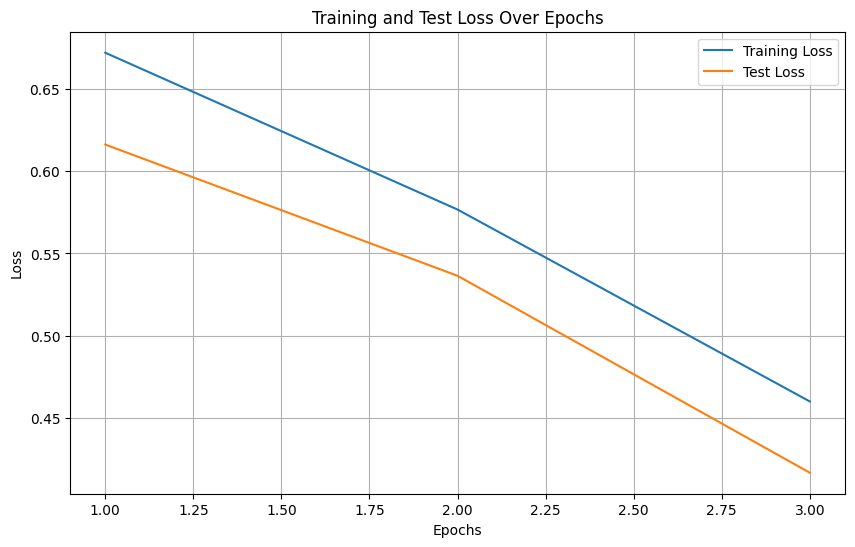

              precision    recall  f1-score   support

           0       0.91      0.89      0.90        45
           1       0.82      0.85      0.84        27

    accuracy                           0.88        72
   macro avg       0.87      0.87      0.87        72
weighted avg       0.88      0.88      0.88        72



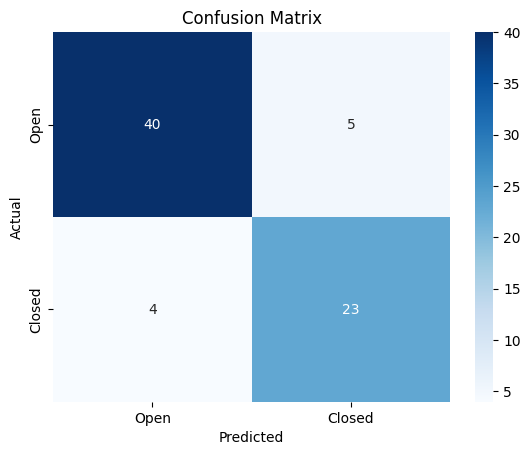

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '/content/finaldataset.xlsx'
data = pd.read_excel(file_path)

# Preprocess the data
X = data[['Question', 'Context', 'Answer']]
y = data['Label'].tolist()  # Ensure labels are a list

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 1: LDA Topic Modeling
vectorizer = CountVectorizer(max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train['Question'])
X_test_vec = vectorizer.transform(X_test['Question'])

# Train LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=42)
X_train_lda = lda.fit_transform(X_train_vec)
X_test_lda = lda.transform(X_test_vec)

# Step 2: Fine-tuning BERT with a classification head
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define custom dataset class
class QuestionDataset(Dataset):
    def __init__(self, questions, context, answer, labels):
        self.questions = questions.tolist()
        self.context = context.tolist()
        self.answer = answer.tolist()
        self.labels = labels

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        inputs = tokenizer(
            self.questions[idx] + " " + self.context[idx] + " " + self.answer[idx],
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors="pt"
        )
        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create Dataloaders
train_dataset = QuestionDataset(X_train['Question'], X_train['Context'], X_train['Answer'], y_train)
test_dataset = QuestionDataset(X_test['Question'], X_test['Context'], X_test['Answer'], y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Define training parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model = bert_model.to(device)
optimizer = AdamW(bert_model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# Step 3: Train the model
def train_model(model, train_loader, test_loader, optimizer, criterion, device, epochs=3):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        # Training phase
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluation phase
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_test_loss += loss.item()

        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

    return train_losses, test_losses

# Run the training and evaluation
train_losses, test_losses = train_model(bert_model, train_loader, test_loader, optimizer, criterion, device, epochs=3)

# Plotting training and test loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Step 4: Evaluate the model
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1).cpu().numpy()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions)

    print(classification_report(y_true, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Open', 'Closed'], yticklabels=['Open', 'Closed'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model
evaluate_model(bert_model, test_loader, device)


              precision    recall  f1-score   support

           0       0.95      0.98      0.96        94
           1       0.98      0.95      0.97       105

    accuracy                           0.96       199
   macro avg       0.96      0.97      0.96       199
weighted avg       0.97      0.96      0.96       199



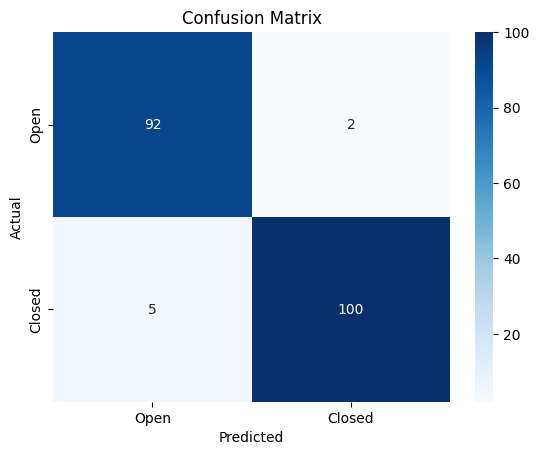

Question: What is the definition of Dijkstra's algorithm? -> Close-ended
Question: Can you suggest multiple ways to optimize a binary search tree? -> Open-ended


In [ ]:
# Step 5: Run the training and evaluation

evaluate_model(bert_model, test_loader, device)

# Test with custom inputs
def classify_custom_questions(questions):
    bert_model.eval()
    custom_inputs = [tokenizer(question, return_tensors="pt", truncation=True, padding='max_length', max_length=128) for question in questions]

    for question, input_data in zip(questions, custom_inputs):
        input_ids = input_data['input_ids'].to(device)
        attention_mask = input_data['attention_mask'].to(device)
        with torch.no_grad():
            outputs = bert_model(input_ids, attention_mask=attention_mask)
            pred = torch.argmax(outputs.logits, dim=-1).item()
            label = 'Open-ended' if pred == 0 else 'Close-ended'
            print(f"Question: {question} -> {label}")

# Custom input testing
custom_questions = [
    "What is the definition of Dijkstra's algorithm?",
    "Can you suggest multiple ways to optimize a binary search tree?"
]

classify_custom_questions(custom_questions)


In [ ]:
torch.save(bert_model, 'bert_lda.pth')

In [ ]:

tokenizer.save_pretrained('bert_ldatoken')


('bert_ldatoken/tokenizer_config.json',
 'bert_ldatoken/special_tokens_map.json',
 'bert_ldatoken/vocab.txt',
 'bert_ldatoken/added_tokens.json')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 - Train Loss: 0.6921, Test Loss: 0.6540
Epoch 2/3 - Train Loss: 0.6100, Test Loss: 0.5603
Epoch 3/3 - Train Loss: 0.4684, Test Loss: 0.4574


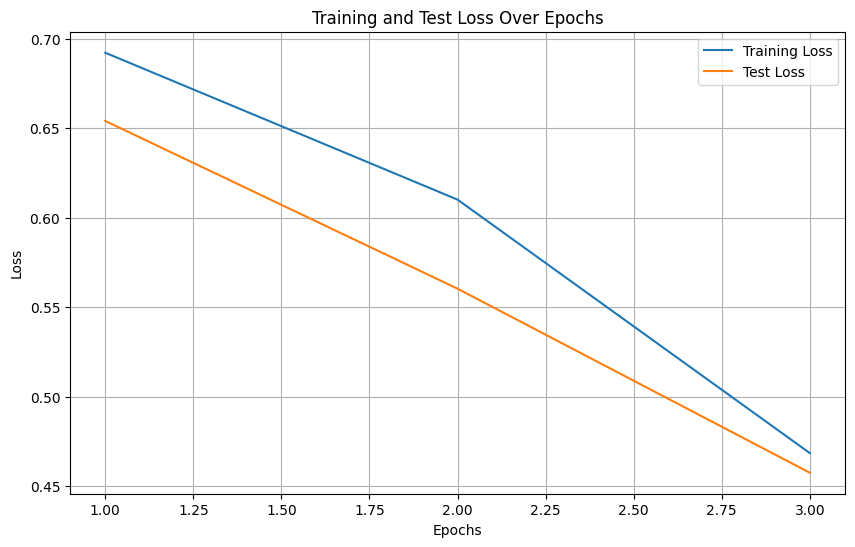

              precision    recall  f1-score   support

           0       0.78      0.88      0.82        32
           1       0.86      0.75      0.80        32

    accuracy                           0.81        64
   macro avg       0.82      0.81      0.81        64
weighted avg       0.82      0.81      0.81        64



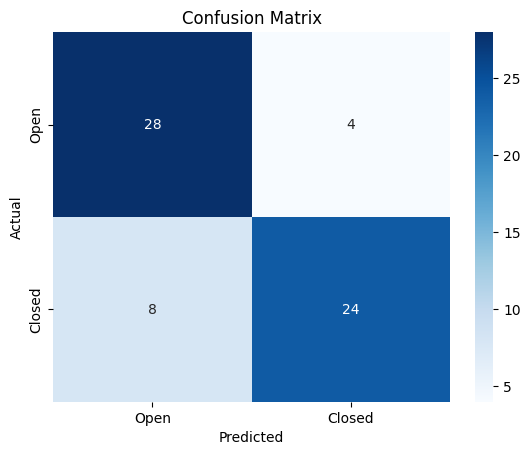

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = '/content/finaldataset.xlsx'
data = pd.read_excel(file_path)

# Preprocess the data
X = data[['Question', 'Context']]
y = data['Label'].astype(int).tolist()  # Ensure labels are integer format

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 1: LDA Topic Modeling
vectorizer = CountVectorizer(max_features=1000)
X_train_vec = vectorizer.fit_transform(X_train['Question'] + " " + X_train['Context'])
X_test_vec = vectorizer.transform(X_test['Question'] + " " + X_test['Context'])

# Train LDA model
lda = LatentDirichletAllocation(n_components=10, random_state=42)
X_train_lda = lda.fit_transform(X_train_vec)
X_test_lda = lda.transform(X_test_vec)

# Step 2: Fine-tuning BERT with a classification head
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define custom dataset class
class QuestionDataset(Dataset):
    def __init__(self, questions, contexts, labels):
        self.questions = questions.values  # Convert to NumPy array
        self.contexts = contexts.values  # Convert to NumPy array
        self.labels = labels

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        text = self.questions[idx] + " " + self.contexts[idx]
        inputs = tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors="pt")
        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create Dataloaders
train_dataset = QuestionDataset(X_train['Question'], X_train['Context'], y_train)
test_dataset = QuestionDataset(X_test['Question'], X_test['Context'], y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=16, drop_last=True)

# Define training parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model = bert_model.to(device)
optimizer = AdamW(bert_model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# Step 3: Train the model
def train_model(model, train_loader, test_loader, optimizer, criterion, device, epochs=3):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        # Training phase
        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Evaluation phase
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_test_loss += loss.item()

        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

    return train_losses, test_losses

# Run the training and evaluation
train_losses, test_losses = train_model(bert_model, train_loader, test_loader, optimizer, criterion, device, epochs=3)

# Plotting training and test loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Step 4: Evaluate the model
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, return_dict=True)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1).cpu().numpy()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions)

    print(classification_report(y_true, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Open', 'Closed'], yticklabels=['Open', 'Closed'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Evaluate the model
evaluate_model(bert_model, test_loader, device)


In [ ]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

# Load BERT tokenizer & model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert = BertModel.from_pretrained("bert-base-uncased")
df=pd.read_excel("/content/finaldataset.xlsx")

# Sample dataset (Replace with actual dataset)
fquestions = df["Question"].to_list()  # List of questions (strings)
fcontext =  df["Context"].to_list()  # Corresponding context (strings)
flabel = df["Label"].to_list() # Labels (0: Open-ended, 1: Closed-ended)

# Function to convert text to BERT embeddings
def text_to_bert_embeddings(text, max_len=20):
    tokens = tokenizer(text, padding="max_length", truncation=True, max_length=max_len, return_tensors="pt")
    with torch.no_grad():
        outputs = bert(**tokens)
    return outputs.last_hidden_state.squeeze(0)  # Shape: (max_len, 768)

# Custom Dataset
class QuestionDataset(Dataset):
    def __init__(self, questions, contexts, labels):
        self.questions = questions
        self.contexts = contexts
        self.labels = labels

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question_tensor = text_to_bert_embeddings(self.questions[idx])
        context_tensor = text_to_bert_embeddings(self.contexts[idx])
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)
        return question_tensor, context_tensor, label_tensor

# Create Dataset & DataLoader
dataset = QuestionDataset(fquestions, fcontext, flabel)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

# CNN-GRU Model
class CNN_GRU(nn.Module):
    def __init__(self, embed_dim=768, conv_out=128, gru_hidden=256, fc_hidden=128, num_classes=2):
        super(CNN_GRU, self).__init__()

        # CNN Layers for Question
        self.conv1_q = nn.Conv1d(embed_dim, conv_out, kernel_size=3, padding=1)
        self.conv2_q = nn.Conv1d(conv_out, conv_out, kernel_size=3, padding=1)

        # CNN Layers for Context
        self.conv1_c = nn.Conv1d(embed_dim, conv_out, kernel_size=3, padding=1)
        self.conv2_c = nn.Conv1d(conv_out, conv_out, kernel_size=3, padding=1)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2)

        # GRU Layer
        self.gru = nn.GRU(input_size=conv_out * 2, hidden_size=gru_hidden, num_layers=2, batch_first=True, bidirectional=True)

        # Fully Connected Layers
        self.fc1 = nn.Linear(gru_hidden * 2, fc_hidden)
        self.fc2 = nn.Linear(fc_hidden, num_classes)

    def forward(self, question, context):
        # CNN on Question
        q = question.permute(0, 2, 1)  # (batch, embed_dim, seq_len)
        q = self.pool(self.relu(self.conv1_q(q)))
        q = self.pool(self.relu(self.conv2_q(q)))

        # CNN on Context
        c = context.permute(0, 2, 1)  # (batch, embed_dim, seq_len)
        c = self.pool(self.relu(self.conv1_c(c)))
        c = self.pool(self.relu(self.conv2_c(c)))

        # Concatenate CNN outputs
        x = torch.cat((q, c), dim=1)  # (batch, conv_out * 2, reduced_seq_len)

        x = x.permute(0, 2, 1)  # (batch, reduced_seq_len, conv_out * 2) for GRU
        x, _ = self.gru(x)
        x = self.fc1(x[:, -1, :])  # Take last GRU output
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Initialize Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_GRU().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for questions, contexts, labels in train_loader:
        questions, contexts, labels = questions.to(device), contexts.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(questions, contexts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")

# Evaluation
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for questions, contexts, labels in test_loader:
        questions, contexts, labels = questions.to(device), contexts.to(device), labels.to(device)
        outputs = model(questions, contexts)
        _, predicted = outputs.max(1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct/total:.2f}%")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Epoch [1/5], Loss: 0.6470, Accuracy: 66.20%
Epoch [2/5], Loss: 0.5199, Accuracy: 78.17%
Epoch [3/5], Loss: 0.5175, Accuracy: 80.63%
Epoch [4/5], Loss: 0.3470, Accuracy: 87.32%
Epoch [5/5], Loss: 0.2467, Accuracy: 91.55%
Test Accuracy: 77.78%


In [ ]:
num_epochs = 5
train_losses, test_losses = [], []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for questions, contexts, labels in train_loader:
        questions, contexts, labels = questions.to(device), contexts.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(questions, contexts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}")

# Evaluation
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    test_loss = 0
    for questions, contexts, labels in test_loader:
        questions, contexts, labels = questions.to(device), contexts.to(device), labels.to(device)
        outputs = model(questions, contexts)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

    test_losses.append(test_loss / len(test_loader))
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
# Classification Report (Precision, Recall, F1-score)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

print(f"\nWeighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Open-ended", "Closed-ended"], yticklabels=["Open-ended", "Closed-ended"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot Loss Graph
plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, num_epochs+1), test_losses, label="Test Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Test Loss")
plt.legend()
plt.show()

Epoch [1/5], Loss: 0.1942
Epoch [2/5], Loss: 0.1412
Epoch [3/5], Loss: 0.1101
Epoch [4/5], Loss: 0.1564
Epoch [5/5], Loss: 0.0419


NameError: name 'precision_recall_fscore_support' is not defined

In [ ]:
!pip install torchtext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 67.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling


Weighted Precision: 0.7956
Weighted Recall: 0.7917
Weighted F1-score: 0.7923


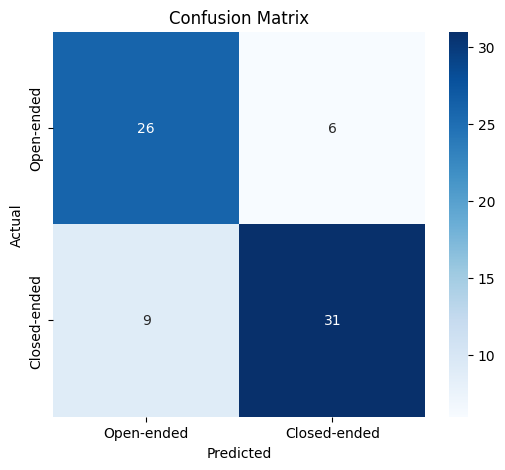

ValueError: x and y must have same first dimension, but have shapes (5,) and (1,)

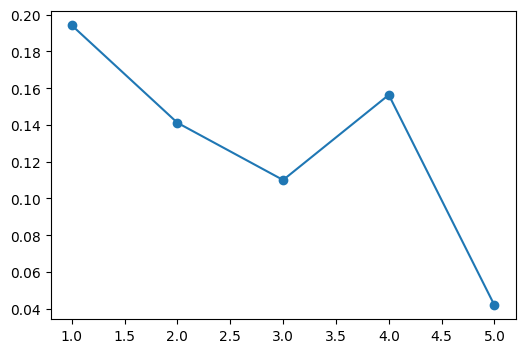

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
# Classification Report (Precision, Recall, F1-score)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
import matplotlib.pyplot as plt
import seaborn as sns
print(f"\nWeighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")
print(f"Weighted F1-score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Open-ended", "Closed-ended"], yticklabels=["Open-ended", "Closed-ended"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot Loss Graph
plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, num_epochs+1), test_losses, label="Test Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Test Loss")
plt.legend()
plt.show()

Epoch [1/5], Train Loss: 0.0245, Test Loss: 1.3602
Epoch [2/5], Train Loss: 0.0071, Test Loss: 1.4616
Epoch [3/5], Train Loss: 0.0175, Test Loss: 1.1345
Epoch [4/5], Train Loss: 0.0684, Test Loss: 0.9507
Epoch [5/5], Train Loss: 0.0403, Test Loss: 1.1983


ValueError: x and y must have same first dimension, but have shapes (5,) and (10,)

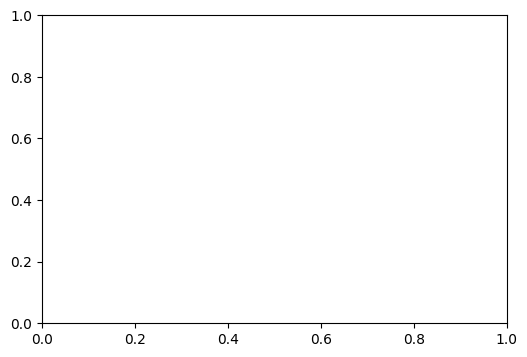

In [ ]:
test_losses = []  # Ensure this starts as an empty list

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for questions, contexts, labels in train_loader:
        questions, contexts, labels = questions.to(device), contexts.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(questions, contexts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))  # Append train loss for each epoch

    # **Evaluation for each epoch**
    model.eval()
    test_loss = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for questions, contexts, labels in test_loader:
            questions, contexts, labels = questions.to(device), contexts.to(device), labels.to(device)
            outputs = model(questions, contexts)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = outputs.max(1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    test_losses.append(test_loss / len(test_loader))  # Append test loss for each epoch

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

# Now train_losses and test_losses have the same length

# **Plot Loss Graph**
plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, num_epochs+1), test_losses, label="Test Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Test Loss")
plt.legend()
plt.show()


In [ ]:
fanswers=df["Answer"].to_list()
fcontexts=df["Context"].to_list()
fquestions=df["Question"].to_list()
flabels=df["Label"].to_list()

Epoch 1, Train Loss: 0.6882
Epoch 1, Test Loss: 0.6671
Epoch 2, Train Loss: 0.6664
Epoch 2, Test Loss: 0.6635
Epoch 3, Train Loss: 0.6333
Epoch 3, Test Loss: 0.6078
Epoch 4, Train Loss: 0.5808
Epoch 4, Test Loss: 0.5505
Epoch 5, Train Loss: 0.5821
Epoch 5, Test Loss: 0.5546


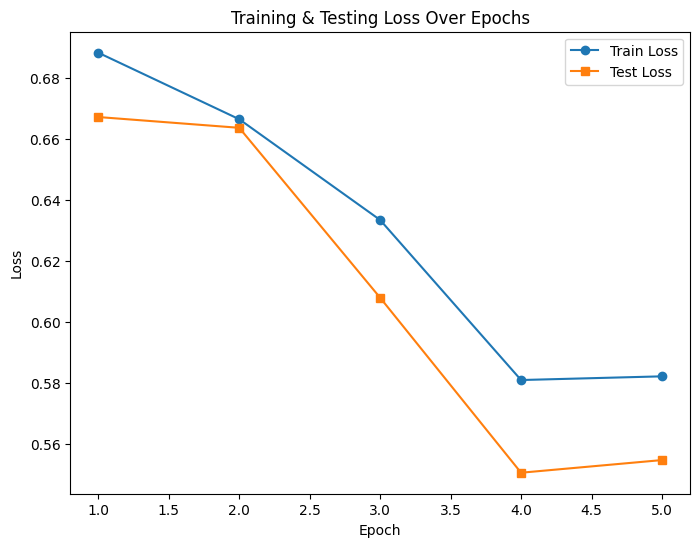

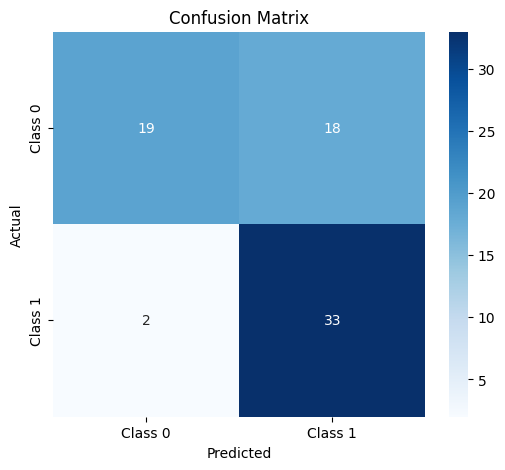


**Classification Report**
Weighted Precision: 0.7795
Weighted Recall: 0.7222
Weighted F1: 0.7097
Macro Precision: 0.7759
Macro Recall: 0.7282
Macro F1: 0.7113


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import BertTokenizer, BertModel
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased").to(device)

# Dataset class
class QuestionDataset(Dataset):
    def __init__(self, questions, answers, contexts, labels, tokenizer, max_length=512):
        self.questions = questions
        self.answers = answers
        self.contexts = contexts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.questions)

    def __getitem__(self, idx):
        question_enc = self.tokenizer(self.questions[idx], padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        answer_enc = self.tokenizer(self.answers[idx], padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        context_enc = self.tokenizer(self.contexts[idx], padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")

        label = torch.tensor(self.labels[idx], dtype=torch.long)

        return (
            question_enc.input_ids.squeeze(0),
            answer_enc.input_ids.squeeze(0),
            context_enc.input_ids.squeeze(0),
            label
        )

# Create dataset
dataset = QuestionDataset(fquestions, fanswers, fcontexts, flabels, tokenizer)

# Split into train and test sets (80% Train, 20% Test)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Model Definition
class QAClassifier(nn.Module):
    def __init__(self, model):
        super(QAClassifier, self).__init__()
        self.encoder = model
        self.fc = nn.Linear(768 * 3, 2)  # 768 * 3 because we concatenate embeddings

    def forward(self, question, answer, context):
        q_emb = self.encoder(question).pooler_output
        a_emb = self.encoder(answer).pooler_output
        c_emb = self.encoder(context).pooler_output

        combined = torch.cat((q_emb, a_emb, c_emb), dim=1)
        output = self.fc(combined)

        return output

# Initialize model
model = QAClassifier(bert_model).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Training loop
epochs = 5
train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        question, answer, context, label = batch
        question, answer, context, label = (
            question.to(device),
            answer.to(device),
            context.to(device),
            label.to(device)
        )

        optimizer.zero_grad()
        outputs = model(question, answer, context)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}")

    # Evaluate on test set
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for batch in test_loader:
            question, answer, context, label = batch
            question, answer, context, label = (
                question.to(device),
                answer.to(device),
                context.to(device),
                label.to(device)
            )

            outputs = model(question, answer, context)
            loss = criterion(outputs, label)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    print(f"Epoch {epoch+1}, Test Loss: {avg_test_loss:.4f}")

# Plot train/test loss
plt.figure(figsize=(8,6))
plt.plot(range(1, epochs+1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss', marker='s')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Testing Loss Over Epochs")
plt.legend()
plt.show()

# Testing loop and performance metrics
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        question, answer, context, label = batch
        question, answer, context, label = (
            question.to(device),
            answer.to(device),
            context.to(device),
            label.to(device)
        )

        outputs = model(question, answer, context)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(label.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Precision, Recall, F1-Score
report = classification_report(y_true, y_pred, target_names=["Class 0", "Class 1"], output_dict=True)

print("\n**Classification Report**")
print(f"Weighted Precision: {report['weighted avg']['precision']:.4f}")
print(f"Weighted Recall: {report['weighted avg']['recall']:.4f}")
print(f"Weighted F1: {report['weighted avg']['f1-score']:.4f}")

print(f"Macro Precision: {report['macro avg']['precision']:.4f}")
print(f"Macro Recall: {report['macro avg']['recall']:.4f}")
print(f"Macro F1: {report['macro avg']['f1-score']:.4f}")


IndexError: Dimension out of range (expected to be in range of [-3, 2], but got 3)

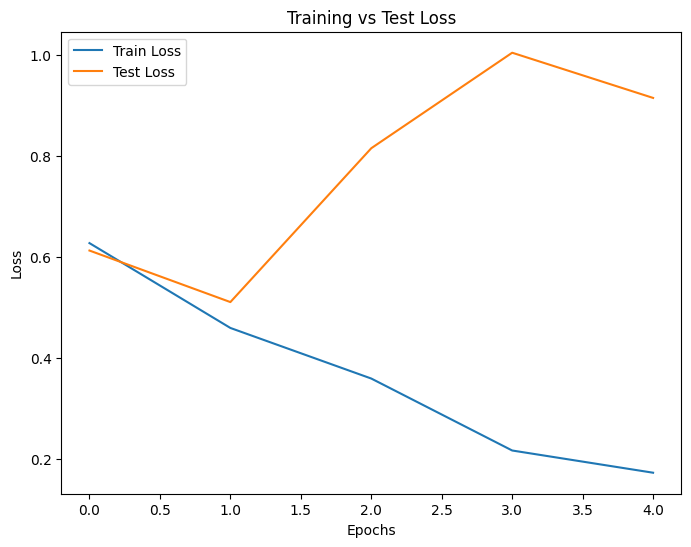

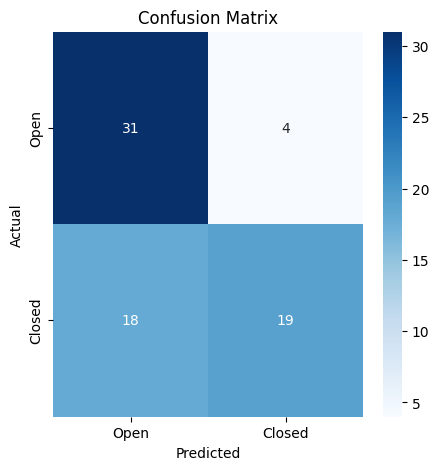

Precision (Weighted): 0.7321
Recall (Weighted): 0.6944
F1-score (Weighted): 0.6843
Precision (Macro): 0.7294
Recall (Macro): 0.6996
F1-score (Macro): 0.6857
F1-score (Class 1): 0.6333
F1-score (Class 2): 0.7381
